# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [99]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, classification_report, recall_score, make_scorer, accuracy_score, precision_score, f1_score 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn import svm
from sklearn.naive_bayes import ComplementNB, BernoulliNB

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load data from database
engine = create_engine('sqlite:///clean_f8.db')
df = pd.read_sql_table('clean_f8_2', con=engine)
df.drop('child_alone', axis=1, inplace=True)
X = df['message']
Y = df[df.columns[4:]]

In [34]:
df.shape

(26216, 40)

In [30]:
pd.set_option('display.max_colwidth', None)
df[df['aid_related'] == 1][['message']].head(20)

,message
1,Is the Hurricane over or is it not over
3,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
7,"Please, we need tents and water. We are in Silo, Thank you!"
9,I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in Santo 15. ( an area in Croix-des-Bouquets )
10,"There's nothing to eat and water, we starving and thirsty."
12,"I am in Thomassin number 32, in the area named Pyron. I would like to have some water. Thank God we are fine, but we desperately need water. Thanks"
13,"Let's do it together, need food in Delma 75, in didine area"
15,"A Comitee in Delmas 19, Rue ( street ) Janvier, Impasse Charite #2. We have about 500 people in a temporary shelter and we are in dire need of Water, Food, Medications, Tents and Clothes. Please stop by and see us."
16,We need food and water in Klecin 12. We are dying of hunger. Impasse Chretien Klecin 12 extended ( extension ) We are hungry and sick.
21,"I'm in Laplaine, I am a victim"


In [33]:
df[['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']].mean()

related                   0.766478
request                   0.170659
offer                     0.004501
aid_related               0.414251
medical_help              0.079493
medical_products          0.050084
search_and_rescue         0.027617
security                  0.017966
military                  0.032804
child_alone               0.000000
water                     0.063778
food                      0.111497
shelter                   0.088267
clothing                  0.015449
money                     0.023039
missing_people            0.011367
refugees                  0.033377
death                     0.045545
other_aid                 0.131446
infrastructure_related    0.065037
transport                 0.045812
buildings                 0.050847
electricity               0.020293
tools                     0.006065
hospitals                 0.010795
shops                     0.004577
aid_centers               0.011787
other_infrastructure      0.043904
weather_related     

In [36]:
df[['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']].sum(axis=1).value_counts()

0     6122
1     5309
3     3609
5     2956
4     2276
6     1903
7     1347
8      880
9      577
2      443
10     344
11     183
12     107
13      57
14      38
15      20
17      12
16       8
18       7
19       5
20       4
21       4
22       2
27       2
24       1
dtype: int64

### 2. Write a tokenization function to process your text data

In [3]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
        
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
        
    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [4]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier())),
        ])

In [146]:
Y.columns.values

array(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related',
       'transport', 'buildings', 'electricity', 'tools', 'hospitals',
       'shops', 'aid_centers', 'other_infrastructure', 'weather_related',
       'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'], dtype=object)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

pipeline.fit(X_train, Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000001D1B11EE790>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [12]:
Y_pred = pipeline.predict(X_test)

In [13]:
categories = Y.columns.values
for i, cat in enumerate(categories):
    print(cat)
    print(classification_report(Y_test.iloc[:,i], Y_pred[:,i]))

related
              precision    recall  f1-score   support

           0       0.73      0.27      0.39      1465
           1       0.82      0.97      0.89      5089

    accuracy                           0.81      6554
   macro avg       0.77      0.62      0.64      6554
weighted avg       0.80      0.81      0.78      6554

request
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      5412
           1       0.89      0.44      0.59      1142

    accuracy                           0.89      6554
   macro avg       0.89      0.72      0.76      6554
weighted avg       0.89      0.89      0.88      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6520
           1       0.00      0.00      0.00        34

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      655

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6014
           1       0.90      0.29      0.44       540

    accuracy                           0.94      6554
   macro avg       0.92      0.64      0.70      6554
weighted avg       0.94      0.94      0.92      6554

storm
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5943
           1       0.79      0.38      0.51       611

    accuracy                           0.93      6554
   macro avg       0.87      0.68      0.74      6554
weighted avg       0.93      0.93      0.92      6554

fire
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6490
           1       0.00      0.00      0.00        64

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.98      0.99      0.99      6554

earthqua

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6. Improve your model
Use grid search to find better parameters. 

In [34]:
ComplementNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'norm': False}

In [66]:
params_grid = [{
                'clf': [MultiOutputClassifier(RandomForestClassifier())],
                'clf__estimator__min_samples_split': [3, 5, 10],
                'clf__estimator__max_depth': [3, 5, 15, 25],
                'clf__estimator__max_features': [3, 5, 10],
                'clf__estimator__n_estimators': [100, 200],
                'clf__estimator__class_weight': ['balanced'],
                },
#                 {           
#                 'clf': [MultiOutputClassifier(svm.SVC())],
#                 'clf__estimator__C': [0.1, 1, 10, 100, 1000],
#                 'clf__estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#                 'clf__estimator__class_weight': ['balanced'],
#                 },
#                 {
#                 'clf': [MultiOutputClassifier(BernoulliNB()), MultiOutputClassifier(ComplementNB())],
#                 'clf__estimator__alpha': [1, 100, 1000, 5000]
#                 }

]

scorers = {
    'precision_score': make_scorer(precision_score, average='macro'),
    'recall_score': make_scorer(recall_score, average='macro'),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score, average='macro')
}

cv = GridSearchCV(pipeline, param_grid=params_grid, scoring=scorers, refit='f1_score', error_score='raise', return_train_score=True, verbose=3, n_jobs=8)

In [42]:
parameters = {
    'clf':  [MultiOutputClassifier(BernoulliNB()), 
             MultiOutputClassifier(ComplementNB()), 
             MultiOutputClassifier(svm.SVC()),]}


cv = GridSearchCV(pipeline, param_grid=parameters, verbose=3, n_jobs=6)

In [67]:
cv.fit(X_train, Y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000001D1B11EE790>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             n_jobs=8,
             param_grid=[{'clf': [MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                         max_depth=1...
                          'clf__estimator__min_samples_split': [3, 5, 10],
                          'clf__estimator__n_estimators': [100, 200]}],
             refit='f1_score', return_train_score=True,
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=macro),
   

In [75]:
Y_pred = cv.predict(X_test)

In [68]:
cv_results = pd.DataFrame(cv.cv_results_)
cv_results2 = cv_results.sort_values(by='mean_test_precision_score', ascending=False)
cv_results2[['mean_test_precision_score', 'mean_test_recall_score', 
             'mean_test_accuracy_score', 'param_clf__estimator__max_depth', 
             'param_clf__estimator__max_features', 'param_clf__estimator__min_samples_split', 
             'param_clf__estimator__n_estimators']]

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_clf__estimator__max_depth,param_clf__estimator__max_features,param_clf__estimator__min_samples_split,param_clf__estimator__n_estimators
67,0.426348,0.239916,0.150494,25,10,3,200
69,0.405290,0.258880,0.146576,25,10,5,200
71,0.404295,0.282399,0.142406,25,10,10,200
61,0.388285,0.224794,0.124859,25,5,3,200
65,0.359745,0.264053,0.112653,25,5,10,200
...,...,...,...,...,...,...,...
10,0.148328,0.340726,0.000356,3,5,10,100
6,0.147859,0.345635,0.000051,3,5,3,100
2,0.137893,0.376284,0.000000,3,3,5,100
0,0.137729,0.346403,0.000000,3,3,3,100


In [81]:
p, r, thresholds = precision_recall_curve(Y_test, Y_pred)

ValueError: multilabel-indicator format is not supported

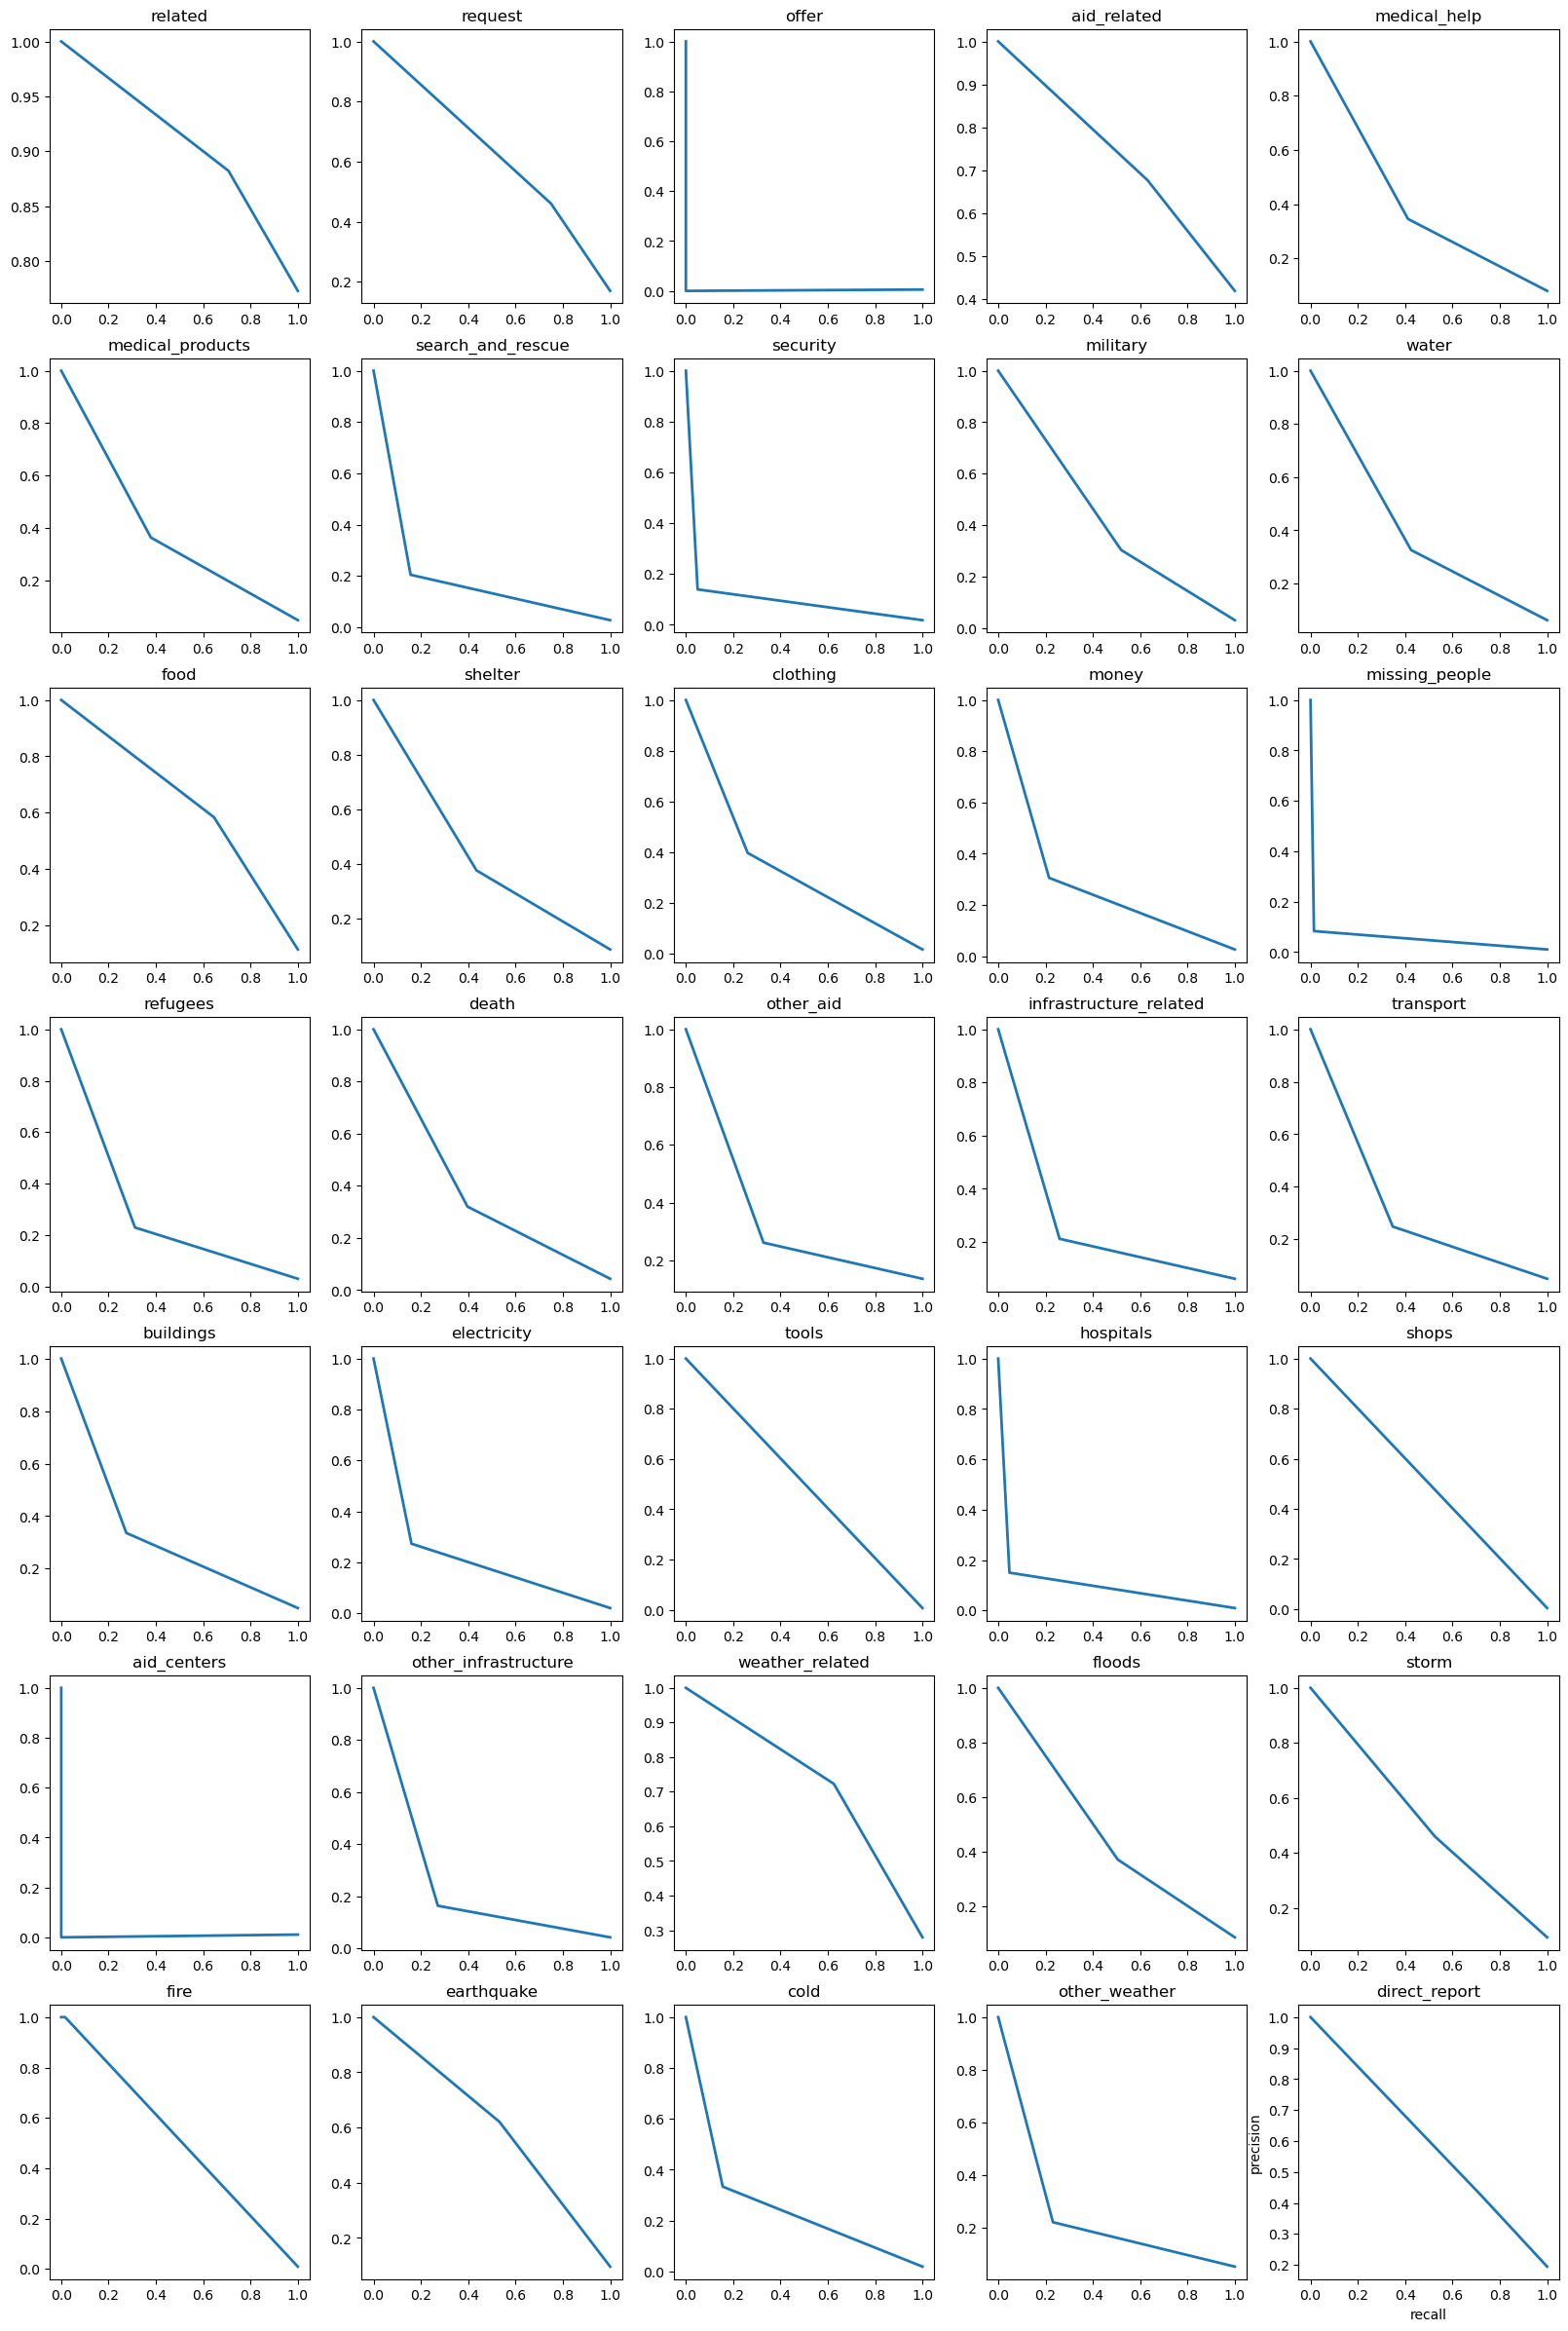

In [126]:
precision = dict()
recall = dict()
fig, axs = plt.subplots(7, 5, figsize=(20, 30))
row = 0
col = 0
for i, cat in enumerate(categories):
    precision[i], recall[i], _ = precision_recall_curve(Y_test.iloc[:, i],
                                                        Y_pred[:, i])
    axs[row, col].plot(recall[i], precision[i], lw=2)
    axs[row, col].set_title(cat)
    col += 1
    if col == 5:
        row += 1
        col = 0
    
plt.xlabel("recall")
plt.ylabel("precision")
#plt.legend(categories, bbox_to_anchor=(1.5, 1), loc='upper right')
#plt.title("precision vs. recall curve")
plt.show()

In [116]:
len(categories)

35

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [76]:
    labels = np.unique(Y_pred)
    confusion_mat = multilabel_confusion_matrix(Y_test, Y_pred, labels=labels)
    accuracy = (Y_pred == Y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Model Accuracy:", accuracy.mean())
    print("Accuracy Breakdown:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

Labels: [0 1]
Confusion Matrix:
 [[[1010  478]
  [1485 3581]]

 [[4464  978]
  [ 278  834]]]
Model Accuracy: 0.9145734338898818
Accuracy Breakdown: related                   0.700488
request                   0.808361
offer                     0.992981
aid_related               0.719408
medical_help              0.890449
medical_products          0.936985
search_and_rescue         0.960330
security                  0.976808
military                  0.948428
water                     0.909673
food                      0.906469
shelter                   0.886634
clothing                  0.980775
money                     0.966585
missing_people            0.987946
refugees                  0.946597
death                     0.936680
other_aid                 0.781507
infrastructure_related    0.894721
transport                 0.915471
buildings                 0.936680
electricity               0.974672
tools                     0.993439
hospitals                 0.988251
shops       

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [77]:
categories = Y.columns.values
for i, cat in enumerate(categories):
    print(cat)
    print(classification_report(Y_test.iloc[:,i], Y_pred[:,i]))


related
              precision    recall  f1-score   support

           0       0.40      0.68      0.51      1488
           1       0.88      0.71      0.78      5066

    accuracy                           0.70      6554
   macro avg       0.64      0.69      0.65      6554
weighted avg       0.77      0.70      0.72      6554

request
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      5442
           1       0.46      0.75      0.57      1112

    accuracy                           0.81      6554
   macro avg       0.70      0.79      0.72      6554
weighted avg       0.86      0.81      0.82      6554

offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6519
           1       0.00      0.00      0.00        35

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      655

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### 9. Export your model as a pickle file

In [132]:
cv.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000001D1B11EE790>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=15,
                                                                        max_features=10,
                                                                        min_samples_split=10,
                                                                        n_estimators=200)))])

In [134]:
import joblib
joblib.dump(cv.best_estimator_, 'pipeline1.pkl')

['pipeline1.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [140]:
# import packages
import sys
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import multilabel_confusion_matrix, classification_report, recall_score, make_scorer, accuracy_score, precision_score, f1_score 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier

from sqlalchemy import create_engine

import joblib

def load_data(data_file):
    ''' A function made to grab local data from a sqlite database and prepare it for ML processes.
    INPUT: data_file: a string with the name of the file to be pulled.
    OUTPUTS: X, y: pandas DataFrame objects.
                X: Input variables.
                y: output variables.
    '''
    # read in file
    engine = create_engine('sqlite:///{}'.format(data_file))
    df = pd.read_sql_table(data_file, con=engine)
    
    # clean data
    df.drop('child_alone', axis=1, inplace=True)

    # define features and label arrays
    X = df['message']
    y = df[df.columns[4:]]

    return X, y


def build_model():
    ''' A function that creates a ML pipeline and outlines parameters for a grid search.
    INPUTS: none
    OUTPUT: model_pipeline. A scikit-learn GridSearchCV object ready to be fitted.
    '''
    
    # text processing and model pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier())),
        ])

    # define parameters for GridSearchCV
    params_grid = [{
                    'clf': [MultiOutputClassifier(RandomForestClassifier())],
                    'clf__estimator__min_samples_split': [5, 10],
                    'clf__estimator__max_depth': [5, 15, 25],
                    'clf__estimator__max_features': [5, 10],
                    'clf__estimator__n_estimators': [100, 200],
                    'clf__estimator__class_weight': ['balanced'],
                    }]
    scorers = {     'precision_score': make_scorer(precision_score, average='macro'),
                    'recall_score': make_scorer(recall_score, average='macro'),
                    'accuracy_score': make_scorer(accuracy_score),
                    'f1_score': make_scorer(f1_score, average='macro')
                    }
    # create gridsearch object and return as final model pipeline
    model_pipeline = GridSearchCV(pipeline, param_grid=params_grid, scoring=scorers, refit='f1_score', 
                      error_score='raise', return_train_score=True, verbose=3, n_jobs=-1)

    return model_pipeline


def train(X, y, model):
    ''' A function that takes previously formatted data and splits it into train and test datasets,
        then fits the data to the previously defined model and outputs the test results.
        
    INPUTS: X, y: pandas DataFrame objects (output by the load_data function).
               X: input variables.
               y: output variables.
            model: a scikit-learn GridSearchCV object (output by the build_model function).
    '''
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # fit model
    model.fit(X_train, y_train)

    # output model test results
    y_pred = cv.predict(X_test)
    model = cv.cv_results_

    return model


def export_model(model):
    ''' A function that exports model results as a pickle file.
    INPUTS: model: A fully modeled and fitted GridSearchCV object.
            model_filepath: a string with the desired filepath to save the model.
    OUTPUT: A pickle file of the model named '{model_filepath}.pkl'
    '''
    # Export model as a pickle file
    joblib.dump(model, 'pipeline.pkl')


def run_pipeline(data_file):
    ''' Runs all functions defined in this document
    INPUT: data_file: A string containing the filename of the data being pulled.
    OUTPUT: none, though see the functions themselves for their respective outputs.
    '''
    X, y = load_data(data_file)  # run ETL pipeline
    model = build_model()  # build model pipeline
    model = train(X, y, model)  # train model pipeline
    export_model(model)  # save model


if __name__ == '__main__':
    data_file = sys.argv[1]  # get filename of dataset
    run_pipeline(data_file)  # run data pipeline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


ValueError: Table -f not found